In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import yaml
import glob
plt.style.use('paper_style.mplstyle')

from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model

from ss_ms_utils import *
from cnn_models import *

### Define some parameters of the TPC

In [19]:
in_to_mm = 25.4

pmt_diam = 2.*in_to_mm # mm, PMT diameter
acceptance = 85. # degrees, PMT acceptance angle

radius_pad = 500. # mm, maximum radius at which photons can be collected
tpc_wall_pad = 400. # mm, buffer to ensure light is not lost to TPC edges

image_width = 2.*radius_pad + 300.
image_height = 2.*radius_pad

radius_tpc = 150. + radius_pad + tpc_wall_pad # mm

# compute array of PMT positions given the PMT diameter and TPC radius
pmt_pos_array = get_pmt_positions(0, 0, diam=pmt_diam, max_rad=radius_tpc)

with open('data/LRF_{:.0f}mm_{:.0f}deg.yaml'.format(pmt_diam, acceptance), 'r') as f:
    lrf_dict = yaml.safe_load(f)

lrf_params = [lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], lrf_dict['b_fit'], lrf_dict['alpha_fit']]

### Choose event sites spread across the central region of the TPC
#### Case 1: single-site events

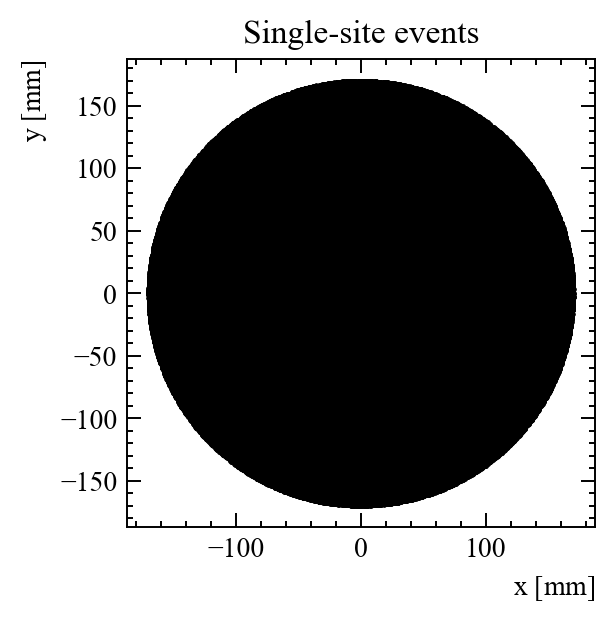

In [68]:
num_events = 250_000 # number of training images for each case
n_photons = 4e1 # number of photons produced in each event *np.ones(num_events)[:, None]

# max_sep = 300. # mm, maximum separation between MS events considered
max_sep = 460 - 40*np.round(2*np.log10(n_photons))

# get twice the number of sites needed since some events (such as those in which downward 
# fluctuations causes no photons to be produced) will end up being discarded
site_ss = get_ss_events(2*num_events, max_sep)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.scatter(site_ss[:,0], site_ss[:,1], s=0.5)
ax.set_aspect('equal')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
ax.set_title('Single-site events')
fig.savefig('ss_event_sites.png')

#### Case 2: multi-site events

/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_57311/3613109859.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('ms_event_sites.png')
/Users/clarke/.venvs/migdal/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


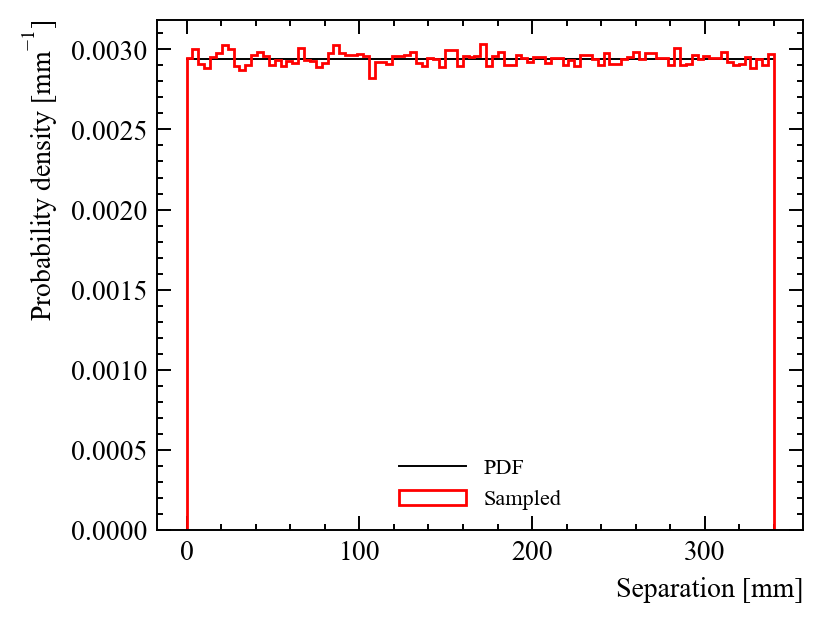

/Users/clarke/.venvs/migdal/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


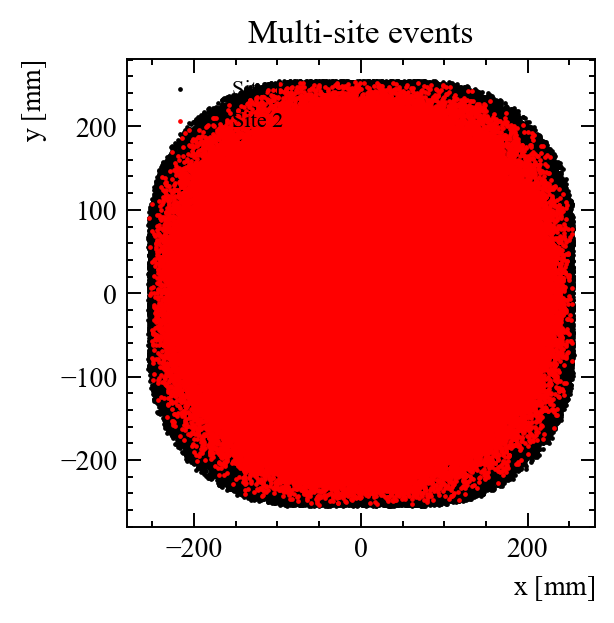

In [69]:
site1, site2 = get_ms_events(2*num_events, max_sep, uniform_separation)

seps_sampled = np.sqrt(np.sum((site1 - site2)**2, axis=1))
sep_array = np.linspace(0, max_sep, 1000)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(sep_array, uniform_separation(sep_array, max_sep/2.), label='PDF')
ax.hist(seps_sampled, bins=100, histtype='step', density=True, label='Sampled')
ax.set_xlabel('Separation [mm]')
ax.set_ylabel('Probability density [mm$^{-1}$]')
ax.legend()
fig.savefig('sep_dist_exp.png')

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.scatter(site1[:,0], site1[:,1], s=0.5, label='Site 1')
ax.scatter(site2[:,0], site2[:,1], s=0.5, label='Site 2')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
ax.set_title('Multi-site events')
ax.legend()
fig.savefig('ms_event_sites.png')

### Compute the number of counts on each PMT

In [70]:
# single site
r_points = np.sqrt(np.sum((site_ss[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts = n_photons*lrf(r_points/10., *lrf_params)
det_counts_ss = np.random.poisson(mean_counts)

# multi site
r_points_1 = np.sqrt(np.sum((site1[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
r_points_2 = np.sqrt(np.sum((site2[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts_1 = 0.5*n_photons*lrf(r_points_1/10., *lrf_params)
mean_counts_2 = 0.5*n_photons*lrf(r_points_2/10., *lrf_params)
det_counts_ms = np.random.poisson(mean_counts_1 + mean_counts_2)

eff = np.mean(np.sum(det_counts_ss, axis=1))/n_photons

: 

### Plot sample PMT hit patterns

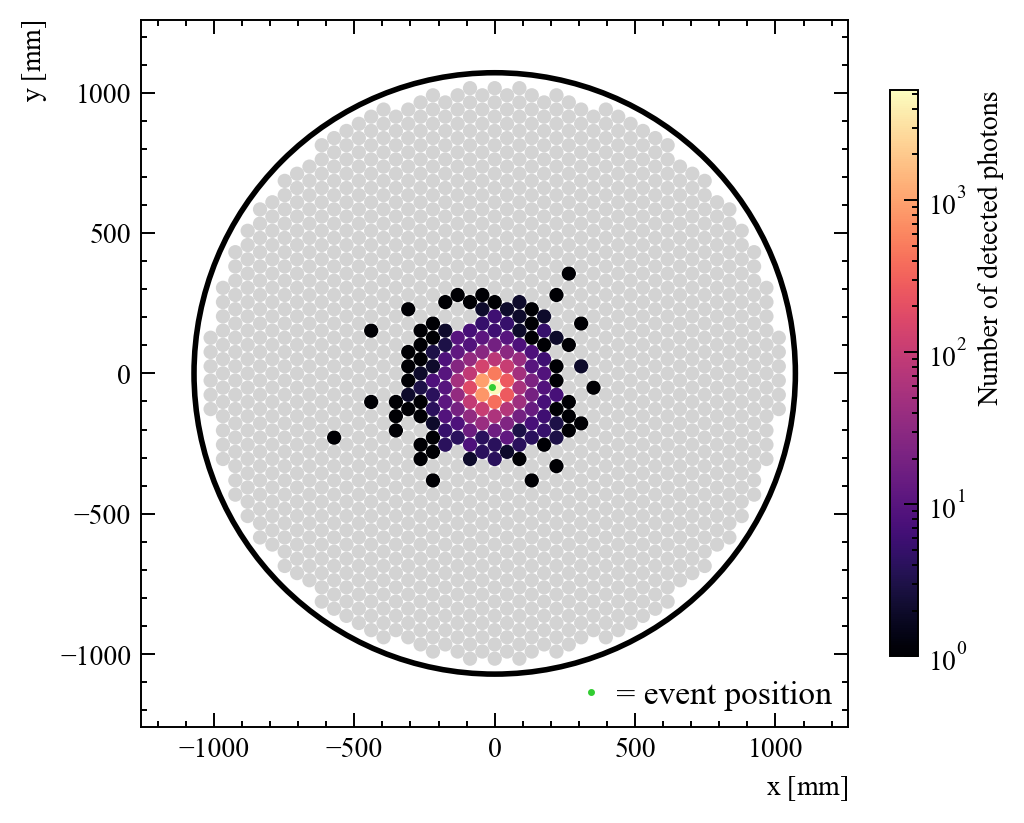

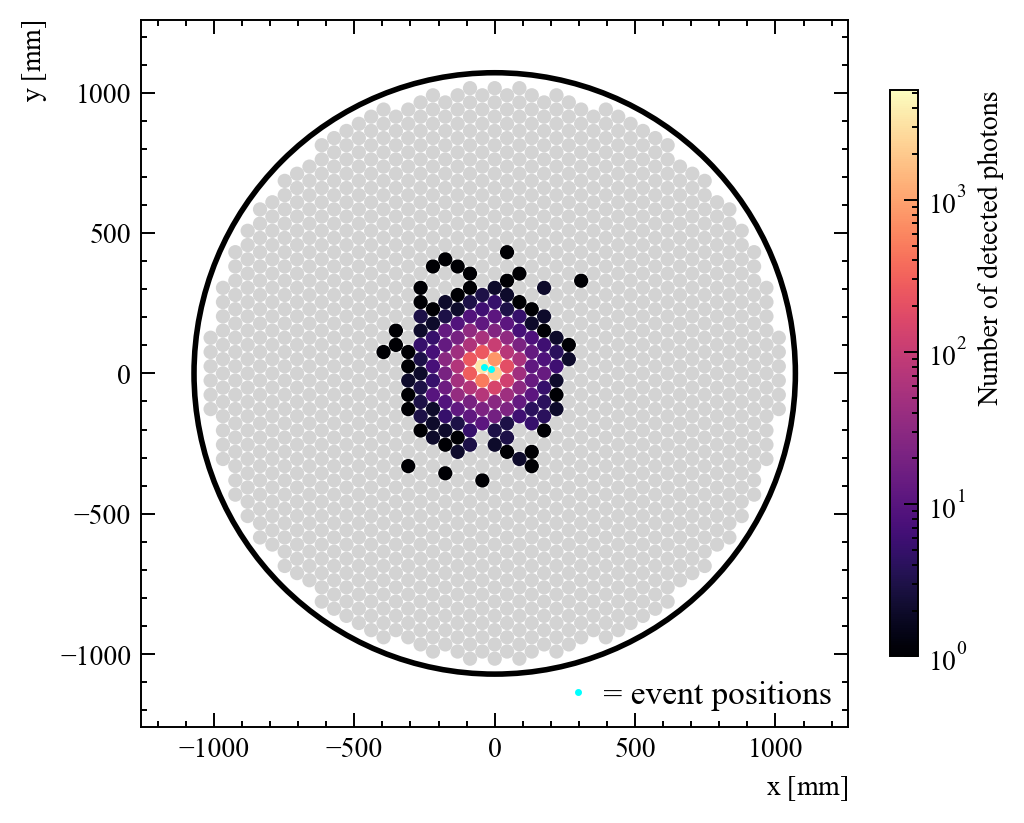

In [24]:
fig, ax = plot_ss_event(site_ss, det_counts_ss, 0, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('hit_pattern_ss.png')
fig, ax = plot_ms_event(site1, site2, det_counts_ms, 2, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('hit_pattern_ms.png')

### Build the training images

In [25]:
images_ms, pmt_indices_ms, event_ids_ms = images_from_events_parallel(det_counts_ms, pmt_pos_array, pmt_diam, image_width, image_height, num_images=num_events)
images_ss, pmt_indices_ss, event_ids_ss = images_from_events_parallel(det_counts_ss, pmt_pos_array, pmt_diam, image_width, image_height, num_images=num_events)

In [18]:
# np.savez('data/hit_pattern_data.npz', det_counts_ms=det_counts_ms, pmt_indices_ms=pmt_indices_ms, \
#          pmt_pos_array=pmt_pos_array, pmt_diam=pmt_diam, radius_tpc=radius_tpc, images_ms=images_ms, \
#          event_ids_ms=event_ids_ms, site1=site1, site2=site2)

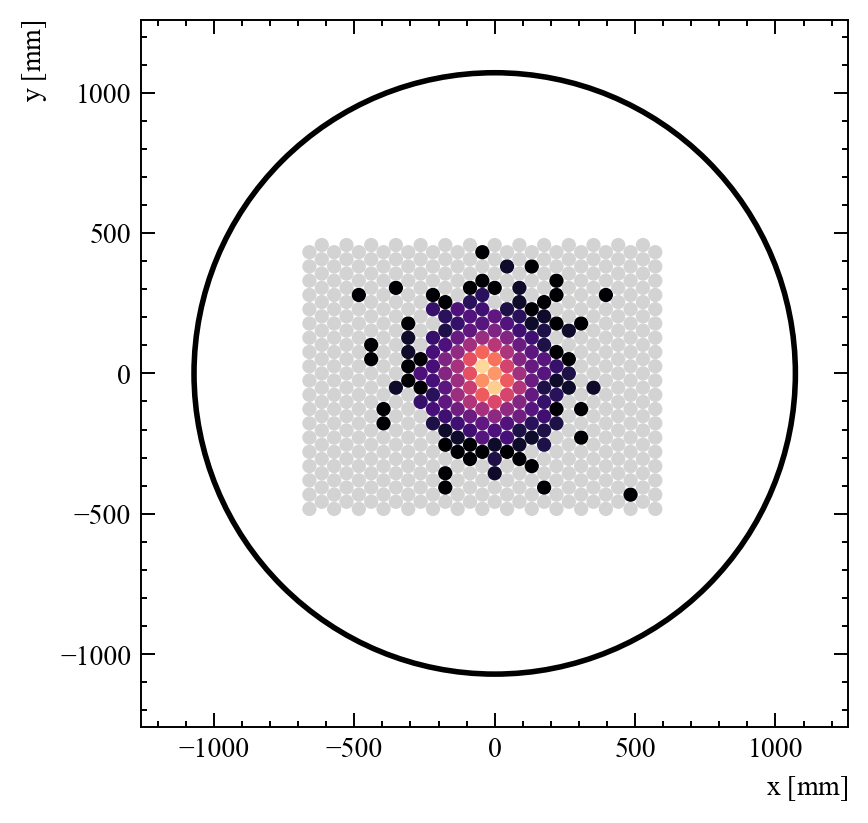

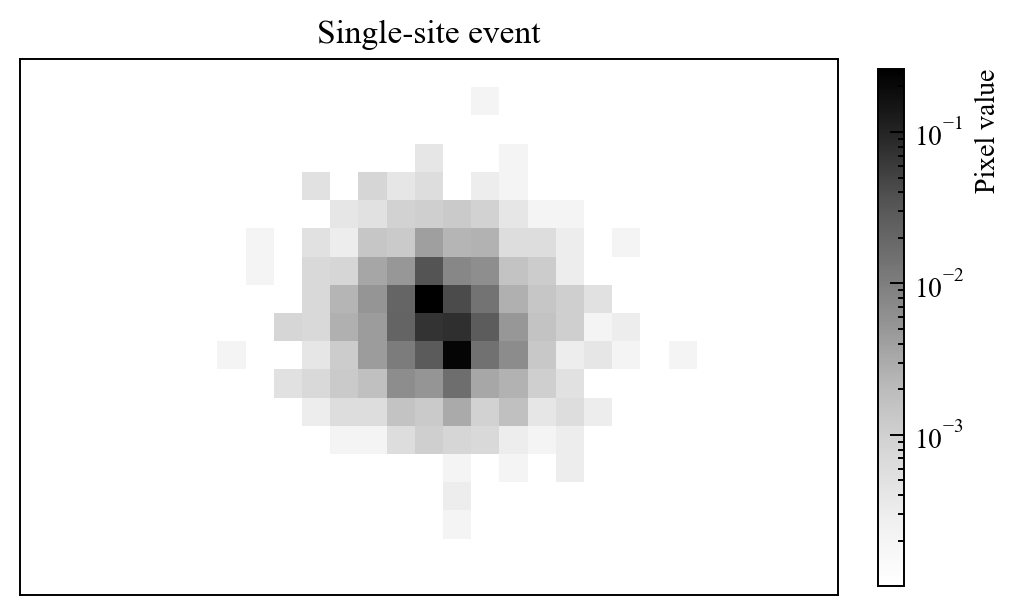

In [26]:
event_id = 4
ind = event_ids_ms[event_id]

fig, _ = plot_selected_pmts(det_counts_ms, pmt_indices_ms, ind, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('ss_selected_pmts.png')

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
im = ax.imshow(images_ms[event_id].T, origin='lower', norm=mcolors.LogNorm(), cmap='Greys')
fig.colorbar(im, shrink=0.66, label='Pixel value')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Single-site event')
fig.savefig('ss_sample_image.png')

### Scramble data and divide into training and validation

In [ ]:
truth_ms = np.zeros(images_ms.shape[0])
truth_ss = np.ones(images_ss.shape[0])

images_all = np.vstack((images_ss, images_ms))
truth_all = np.hstack((truth_ss, truth_ms))

permutation = np.random.permutation(truth_all.shape[0])

images_scrambled = images_all[permutation, ...]
truth_scrambled = truth_all[permutation, ...]

validation_split = 0.2

images_training = images_scrambled[:int(-validation_split*images_scrambled.shape[0])]
truth_training = truth_scrambled[:int(-validation_split*truth_scrambled.shape[0])]
images_validation = images_scrambled[int(-validation_split*images_scrambled.shape[0]):]
truth_validation = truth_scrambled[int(-validation_split*truth_scrambled.shape[0]):]
indices_validation = permutation[int(-validation_split*permutation.shape[0]):]

descrip = 'log'

# np.savez('data/images_{:.0e}_events_{:.0e}_photons_{}.npz'.format(num_events, n_photons, descrip), images_training=images_training, \
#          truth_training=truth_training, images_validation=images_validation, truth_validation=truth_validation, \
#          indices_validation=indices_validation, images_all=images_all, truth_all=truth_all)

# num_events = 50000
# n_photons = 1e4
# loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons.npz'.format(num_events, n_photons))
# images_training = loaded['images_training']
# truth_training = loaded['truth_training']
# images_validation = loaded['images_validation']
# truth_validation = loaded['truth_validation']
# indices_validation = loaded['indices_validation']
# images_all = loaded['images_all']
# truth_all = loaded['truth_all']

(100000, 29, 19, 2)


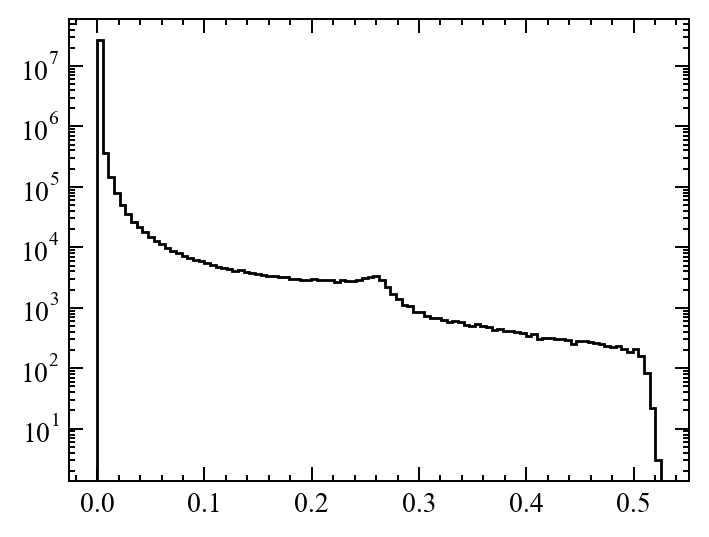

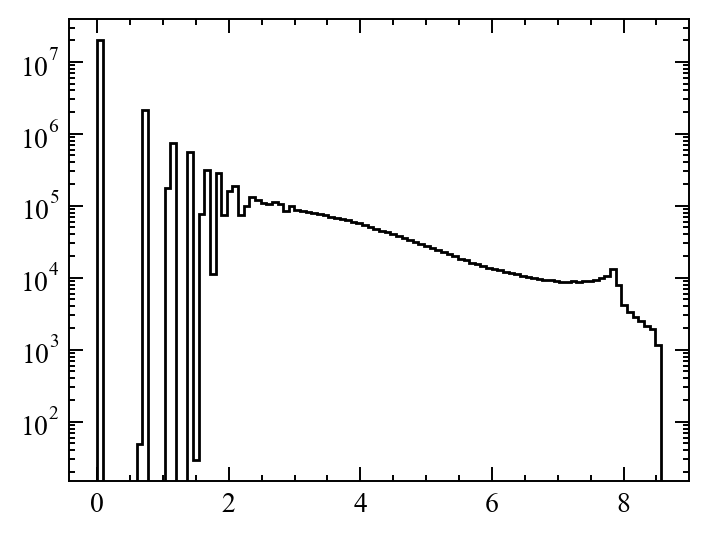

In [56]:
plt.hist(images_ms.ravel(), histtype='step', bins=100)
plt.yscale('log')

plt.figure()
plt.hist(np.log1p(1e4*images_ms).ravel(), histtype='step', bins=100)
plt.yscale('log')

(array([2.6583206e+07, 3.6374700e+05, 1.4587400e+05, 7.9774000e+04,
        5.0253000e+04, 3.5631000e+04, 2.6681000e+04, 2.1350000e+04,
        1.7638000e+04, 1.4701000e+04, 1.2645000e+04, 1.1247000e+04,
        9.7930000e+03, 8.8280000e+03, 8.0400000e+03, 7.1760000e+03,
        6.5870000e+03, 6.2260000e+03, 5.8760000e+03, 5.4620000e+03,
        5.0170000e+03, 4.7620000e+03, 4.5310000e+03, 4.3980000e+03,
        4.1220000e+03, 4.1370000e+03, 3.9560000e+03, 3.7120000e+03,
        3.6770000e+03, 3.4870000e+03, 3.3870000e+03, 3.3550000e+03,
        3.1950000e+03, 3.1820000e+03, 3.0410000e+03, 2.9980000e+03,
        2.9080000e+03, 2.8390000e+03, 2.9350000e+03, 2.8890000e+03,
        2.8270000e+03, 2.8690000e+03, 2.7170000e+03, 2.8540000e+03,
        2.8160000e+03, 2.8190000e+03, 2.9330000e+03, 3.0960000e+03,
        3.2640000e+03, 3.3130000e+03, 2.8620000e+03, 2.2440000e+03,
        1.6960000e+03, 1.3810000e+03, 1.1000000e+03, 1.0580000e+03,
        8.5700000e+02, 8.4100000e+02, 7.3500000e

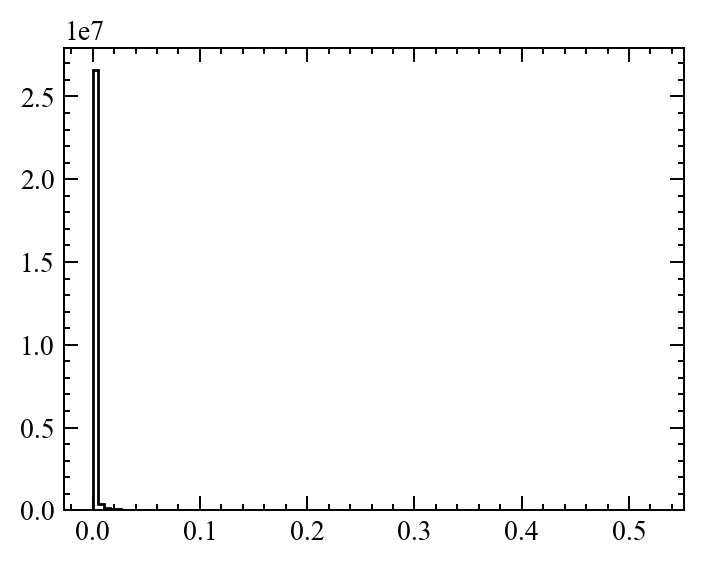

In [37]:
plt.hist(images_ms.ravel(), histtype='step', bins=100)

In [188]:
# num_photons = [1e2, 3e2, 1e3, 3e3, 1e4, 4e4]
# for n_p in num_photons:
#     loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons.npz'.format(num_events, n_p))
#     images_training = loaded['images_training']
#     truth_training = loaded['truth_training']
#     images_validation = loaded['images_validation']
#     truth_validation = loaded['truth_validation']
#     indices_validation = loaded['indices_validation']
#     images_all = loaded['images_all']
#     truth_all = loaded['truth_all']

#     model = ResNet14(input_shape=images_all[0,:,:,None].shape, num_classes=1)
#     model.summary()

#     lr_scheduler = callbacks.LearningRateScheduler(scheduler)
#     earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     history = model.fit(images_training, truth_training,
#         batch_size=128,
#         epochs=30,
#         callbacks=[lr_scheduler, earlystopping],
#         validation_data=(images_validation, truth_validation)
#     )

#     model.save('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_p))

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_153[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_144 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_144[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_145 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_145[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_154[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_146 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_146[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_64 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_155[0][0], │
│                     │                   │            │ re_lu_144[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_64[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_147 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_147[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_156[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_148 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_148[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_65 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_157[0][0], │
│                     │                   │            │ add_64[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_65[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_149 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,945 (265.41 KB)

 Trainable params: 67,177 (262.41 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - AUC: 0.8869 - acc: 0.8572 - loss: 0.3148 - val_AUC: 0.8663 - val_acc: 0.8140 - val_loss: 0.3294 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - AUC: 0.9160 - acc: 0.8997 - loss: 0.2576 - val_AUC: 0.9154 - val_acc: 0.8899 - val_loss: 0.2578 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9174 - acc: 0.9027 - loss: 0.2516 - val_AUC: 0.9174 - val_acc: 0.8993 - val_loss: 0.2492 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9180 - acc: 0.9037 - loss: 0.2482 - val_AUC: 0.9187 - val_acc: 0.9019 - val_loss: 0.2472 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9193 - acc: 0.9043 - loss: 0.2456 - val_AUC: 0.9175 - val_acc: 0.9036 - val_loss: 0.2471 - learning_rate: 1.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - AUC: 0.9203 - acc: 0.9053 - loss: 0.2433 - v

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_172 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_172[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_162 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_162[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_163 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_173 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_163[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_173[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_164 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_164[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_174[0][0], │
│                     │                   │            │ re_lu_162[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_72[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_165 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_165[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_175[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_166 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_166[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_73 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_176[0][0], │
│                     │                   │            │ add_72[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_73[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_167 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,945 (265.41 KB)

 Trainable params: 67,177 (262.41 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - AUC: 0.9204 - acc: 0.8949 - loss: 0.3089 - val_AUC: 0.5024 - val_acc: 0.5032 - val_loss: 1.0248 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9256 - acc: 0.9129 - loss: 0.2392 - val_AUC: 0.9255 - val_acc: 0.9144 - val_loss: 0.2356 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - AUC: 0.9266 - acc: 0.9157 - loss: 0.2301 - val_AUC: 0.9249 - val_acc: 0.9153 - val_loss: 0.2315 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9277 - acc: 0.9173 - loss: 0.2261 - val_AUC: 0.9255 - val_acc: 0.9118 - val_loss: 0.2304 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - AUC: 0.9282 - acc: 0.9178 - loss: 0.2236 - val_AUC: 0.9263 - val_acc: 0.9143 - val_loss: 0.2287 - learning_rate: 1.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - AUC: 0.9291 - acc: 0.9192 - loss: 0.2213 - v

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_180 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_180[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_181 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_181[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_182 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_182[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_193[0][0], │
│                     │                   │            │ re_lu_180[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_80[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_183 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_194 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_183[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_194[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_184 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_184[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_81 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_195[0][0], │
│                     │                   │            │ add_80[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_81[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_185 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,945 (265.41 KB)

 Trainable params: 67,177 (262.41 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - AUC: 0.9264 - acc: 0.9052 - loss: 0.2786 - val_AUC: 0.5647 - val_acc: 0.5181 - val_loss: 0.7395 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9338 - acc: 0.9236 - loss: 0.2178 - val_AUC: 0.9345 - val_acc: 0.9204 - val_loss: 0.2105 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - AUC: 0.9348 - acc: 0.9250 - loss: 0.2104 - val_AUC: 0.9347 - val_acc: 0.9197 - val_loss: 0.2103 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - AUC: 0.9349 - acc: 0.9265 - loss: 0.2075 - val_AUC: 0.9382 - val_acc: 0.9312 - val_loss: 0.2000 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9356 - acc: 0.9275 - loss: 0.2052 - val_AUC: 0.9348 - val_acc: 0.9209 - val_loss: 0.2092 - learning_rate: 1.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - AUC: 0.9356 - acc: 0.9271 - loss: 0.2041 - v

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_210[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_198 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_198[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_199 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_211 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_199[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_211[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_200 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_200[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_88 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_212[0][0], │
│                     │                   │            │ re_lu_198[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_88[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_201 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_213 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_201[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_213[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_202 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_202[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_89 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_214[0][0], │
│                     │                   │            │ add_88[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_89[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_203 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,945 (265.41 KB)

 Trainable params: 67,177 (262.41 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - AUC: 0.8884 - acc: 0.8567 - loss: 0.2958 - val_AUC: 0.5001 - val_acc: 0.5020 - val_loss: 1.9178 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9333 - acc: 0.9225 - loss: 0.2155 - val_AUC: 0.9270 - val_acc: 0.9025 - val_loss: 0.2265 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9347 - acc: 0.9252 - loss: 0.2095 - val_AUC: 0.9344 - val_acc: 0.9219 - val_loss: 0.2088 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - AUC: 0.9359 - acc: 0.9270 - loss: 0.2054 - val_AUC: 0.8932 - val_acc: 0.8500 - val_loss: 0.2790 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9368 - acc: 0.9283 - loss: 0.2025 - val_AUC: 0.9371 - val_acc: 0.9295 - val_loss: 0.2013 - learning_rate: 1.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9376 - acc: 0.9297 - loss: 0.2003 - v

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_229 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_229[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_216 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_216[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_217 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_230 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_217[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_230[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_218 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_231 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_218[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_96 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_231[0][0], │
│                     │                   │            │ re_lu_216[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_96[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_219 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_232 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_219[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_232[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_220 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_233 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_220[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_97 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_233[0][0], │
│                     │                   │            │ add_96[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_97[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_221 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,945 (265.41 KB)

 Trainable params: 67,177 (262.41 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - AUC: 0.9134 - acc: 0.8833 - loss: 0.2857 - val_AUC: 0.5000 - val_acc: 0.5021 - val_loss: 2.0259 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9322 - acc: 0.9193 - loss: 0.2216 - val_AUC: 0.9345 - val_acc: 0.9140 - val_loss: 0.2170 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9326 - acc: 0.9212 - loss: 0.2151 - val_AUC: 0.9331 - val_acc: 0.9233 - val_loss: 0.2161 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - AUC: 0.9335 - acc: 0.9234 - loss: 0.2114 - val_AUC: 0.9326 - val_acc: 0.9257 - val_loss: 0.2129 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - AUC: 0.9336 - acc: 0.9237 - loss: 0.2090 - val_AUC: 0.9354 - val_acc: 0.9229 - val_loss: 0.2063 - learning_rate: 1.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - AUC: 0.9343 - acc: 0.9247 - loss: 0.2077 - v

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_248 (Conv2D) │ (None, 29, 19, 8) │         72 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_248[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_234 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_234[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_235 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_249 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_235[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_249[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_236 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_250 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_236[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_104 (Add)       │ (None, 29, 19, 8) │          0 │ conv2d_250[0][0], │
│                     │                   │            │ re_lu_234[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_104[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_237 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_251 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_237[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_251[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_238 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_252 (Conv2D) │ (None, 29, 19, 8) │        576 │ re_lu_238[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_105 (Add)       │ (None, 29, 19, 8) │          0 │ conv2d_252[0][0], │
│                     │                   │            │ add_104[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_105[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_239 (ReLU)    │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,945 (265.41 KB)

 Trainable params: 67,177 (262.41 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - AUC: 0.8793 - acc: 0.8417 - loss: 0.3263 - val_AUC: 0.5000 - val_acc: 0.4951 - val_loss: 2.4009 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - AUC: 0.9274 - acc: 0.9105 - loss: 0.2318 - val_AUC: 0.9363 - val_acc: 0.9214 - val_loss: 0.2134 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - AUC: 0.9301 - acc: 0.9168 - loss: 0.2223 - val_AUC: 0.8392 - val_acc: 0.7818 - val_loss: 0.3424 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - AUC: 0.9309 - acc: 0.9168 - loss: 0.2192 - val_AUC: 0.9279 - val_acc: 0.9224 - val_loss: 0.2231 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9311 - acc: 0.9185 - loss: 0.2166 - val_AUC: 0.9347 - val_acc: 0.9158 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - AUC: 0.9314 - acc: 0.9187 - loss: 0.2151 - v

### Build and train the CNN

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 29, 19, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 29, 19, 8) │        144 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ re_lu_54[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_55 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_55[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_59[0][0],  │
│                     │                   │            │ re_lu_54[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_24[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_57[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_61[0][0],  │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_25[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_59 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 68,017 (265.69 KB)

 Trainable params: 67,249 (262.69 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - AUC: 0.8591 - acc: 0.8058 - loss: 0.4182 - val_AUC: 0.8832 - val_acc: 0.8589 - val_loss: 0.3332 - learning_rate: 1.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.8937 - acc: 0.8692 - loss: 0.3074 - val_AUC: 0.8928 - val_acc: 0.8608 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9034 - acc: 0.8815 - loss: 0.2833 - val_AUC: 0.8453 - val_acc: 0.7997 - val_loss: 0.3584 - learning_rate: 1.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - AUC: 0.9071 - acc: 0.8881 - loss: 0.2724 - val_AUC: 0.8718 - val_acc: 0.8271 - val_loss: 0.3173 - learning_rate: 1.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - AUC: 0.9112 - acc: 0.8924 - loss: 0.2637 - val_AUC: 0.8796 - val_acc: 0.8457 - val_loss: 0.3091 - learning_rate: 1.0000e-04


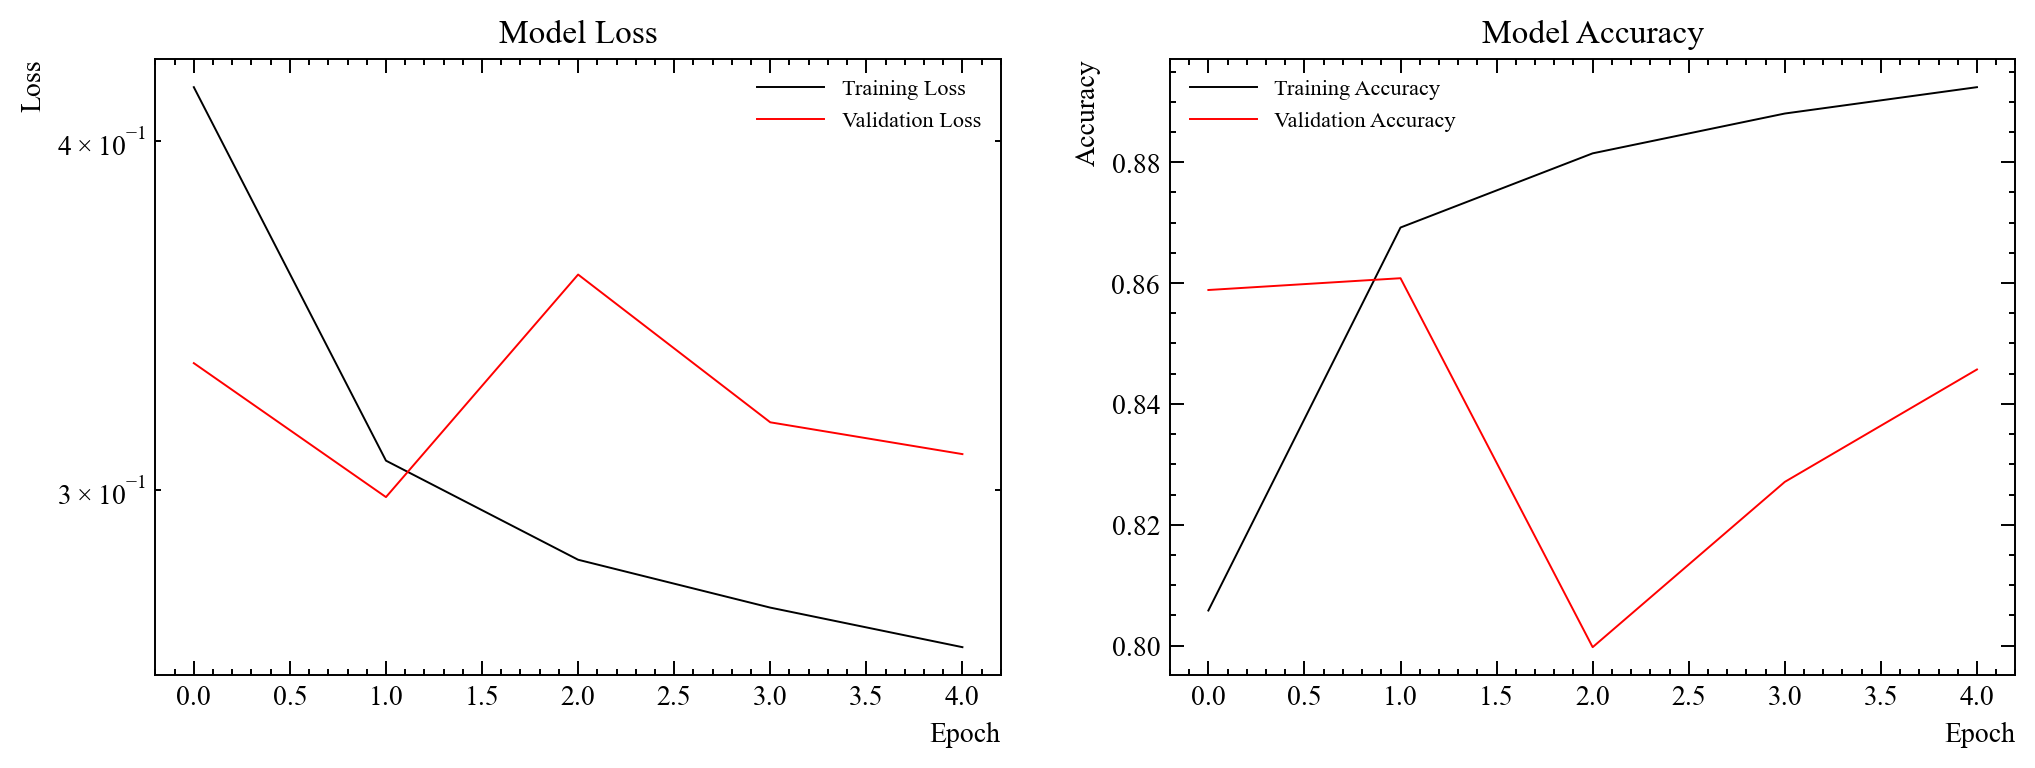

In [67]:
# model = ResNet14(input_shape=images_all[0,:,:,None].shape, num_classes=1)
model = ResNet14(input_shape=images_all[0].shape, num_classes=1)
model.summary()

lr_scheduler = callbacks.LearningRateScheduler(scheduler)
earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(images_training, truth_training,
    batch_size=128,
    epochs=30,
    callbacks=[lr_scheduler, earlystopping],
    validation_data=(images_validation, truth_validation)
)

model.save('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_photons))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_training.png')

### Plot performance on the validation data

In [204]:
n_photons = 3e3
model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_photons))
loaded = np.load('data/images_{:.0e}_events_{:.0e}_photons.npz'.format(num_events, n_photons))
images_training = loaded['images_training']
truth_training = loaded['truth_training']
images_validation = loaded['images_validation']
truth_validation = loaded['truth_validation']
indices_validation = loaded['indices_validation']
images_all = loaded['images_all']
truth_all = loaded['truth_all']

Youden optimal cut keeps 99.1% of signal events and removes 87.6% of background events.


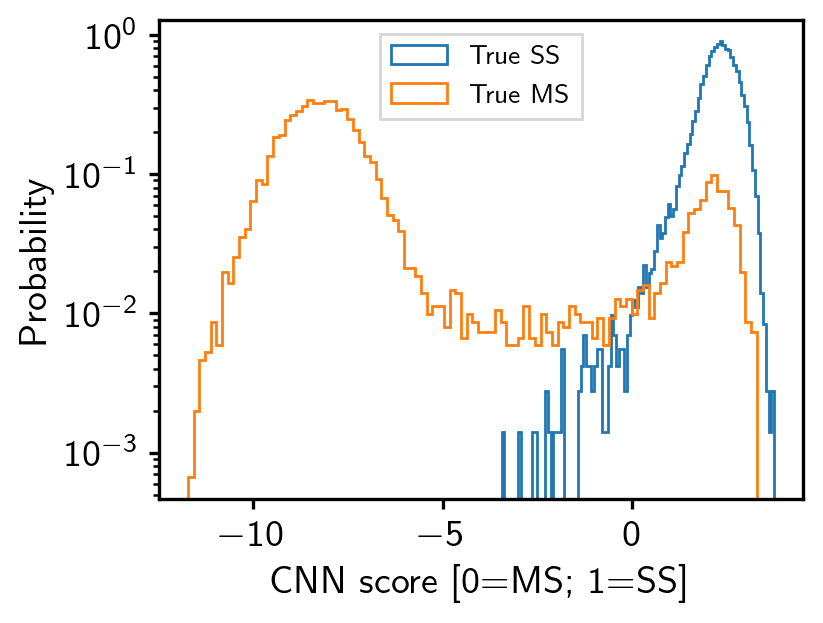

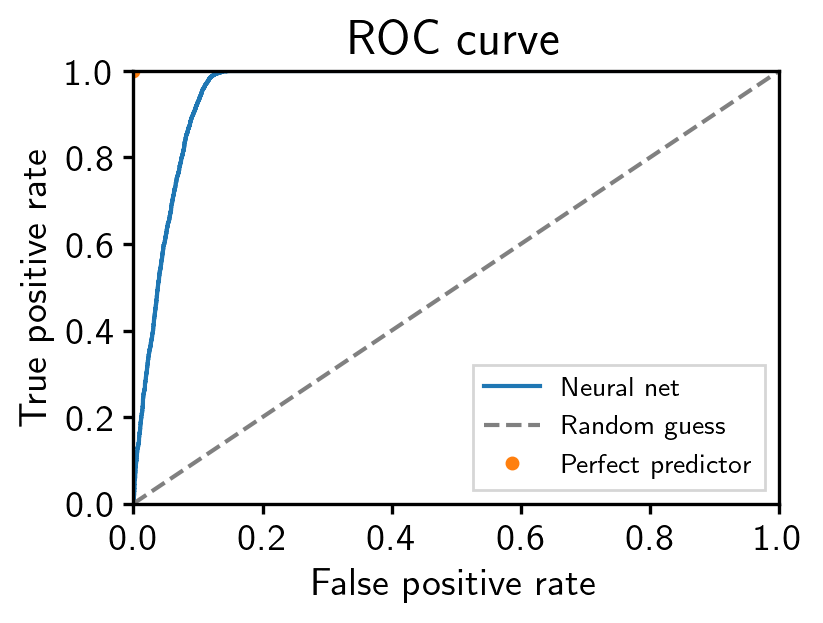

In [205]:
# get the validation data
ss_validation = images_all[indices_validation][indices_validation < images_ss.shape[0]]
ms_validation = images_all[indices_validation][indices_validation >= images_ss.shape[0]]

# run the validation images through the trained model
ss_predictions = model(ss_validation[:,:,:,None], training=False)[:,0].numpy()
ms_predictions = model(ms_validation[:,:,:,None], training=False)[:,0].numpy()

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.hist(ss_predictions, bins=100, histtype='step', density=True, label='True SS')
ax.hist(ms_predictions, bins=100, histtype='step', density=True, label='True MS')
ax.set_yscale('log')
ax.set_xlabel('CNN score [0=MS; 1=SS]')
ax.set_ylabel('Probability')
ax.legend()
fig.savefig('cnn_score_dists.png')

y_pred = np.array(np.array(model(images_validation))[:,0])
y_true = np.copy(truth_validation)

sorted_indices = np.argsort(-y_pred)
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

P = np.sum(y_true)
N = len(y_true) - P

tpr = np.cumsum(y_true_sorted)/P
fpr = np.cumsum(1 - y_true_sorted)/N

youden = tpr - fpr - 1
opt_ind = np.argmax(youden)

print('Youden optimal cut keeps {:.1f}% of signal events and removes {:.1f}% of background events.'\
      .format(100*tpr[opt_ind], 100*(1. - fpr[opt_ind])))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(fpr, tpr, label='Neural net')
ax.plot([0, 1], [0, 1], ls='--', color='grey', label='Random guess')
ax.plot([0], [1], marker='o', ls='none', ms=4, label='Perfect predictor')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')
fig.savefig('cnn_roc.png')

In [237]:
def make_ms_events(n_events, this_sep):
    angle = np.random.uniform(0, 2.*np.pi, n_events)
    site1 = np.zeros((2, n_events)) #np.array((-this_sep*np.cos(angle)/2., -this_sep*np.sin(angle)/2.)) \
            #+ pmt_diam*np.random.rand(2*n_events).reshape((2, n_events))
    site2 = site1 + np.array((this_sep*np.cos(angle), this_sep*np.sin(angle)))
    return site1.T, site2.T

def make_ss_events(num_events, max_sep):
    return np.zeros((num_events, 2))

# thresh = y_pred[sorted_indices[opt_ind]]
seps = np.linspace(4, 30, 20)
num_photons = [1e2, 3e2, 1e3, 3e3, 1e4, 4e4]
acc_test = np.zeros((len(seps), len(num_photons)))
site_test = make_ss_events(1000, pmt_diam)

r_points = np.sqrt(np.sum((site_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))

threshes = []
kept = []
for j, n_p in enumerate(num_photons):
    mean_counts = n_p*lrf(r_points/10., *lrf_params)
    det_counts_test = np.random.poisson(mean_counts)
    images_test, _ = images_from_events(det_counts_test, pmt_pos_array, pmt_diam, image_width, image_height, num_images=1000)
    model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_p))
    preds = model(images_test[:,:,:,None], training=False)[:,0].numpy()
    threshes.append(np.median(preds))
    kept.append(np.sum(preds > threshes[-1]))

for i, this_sep in enumerate(seps):
    site1_test, site2_test = make_ms_events(1000, this_sep)
    
    r_points_1 = np.sqrt(np.sum((site1_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
    r_points_2 = np.sqrt(np.sum((site2_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))

    for j, n_p in enumerate(num_photons):
        mean_counts_1 = 0.5*n_p*lrf(r_points_1/10., *lrf_params)
        mean_counts_2 = 0.5*n_p*lrf(r_points_2/10., *lrf_params)
        det_counts_test = np.random.poisson(mean_counts_1 + mean_counts_2)
        images_test, _ = images_from_events(det_counts_test, pmt_pos_array, pmt_diam, image_width, image_height, num_images=1000)
        model = load_model('data/' + model.name + '_{:.0e}_events_{:.0e}_photons.keras'.format(num_events, n_p))
        preds = model(images_test[:,:,:,None], training=False)[:,0].numpy()
        acc_test[i, j] = np.sum(preds < threshes[j])

resolutions = []
for j in range(len(num_photons)):
    ind = np.argmin(np.abs(np.interp(np.linspace(0, np.amax(seps), 1000), seps, np.array(acc_test[:, j])/1000*1e2) - 84.))
    resolutions.append(np.linspace(0, np.amax(seps), 1000)[ind])
resolutions = np.array(resolutions)

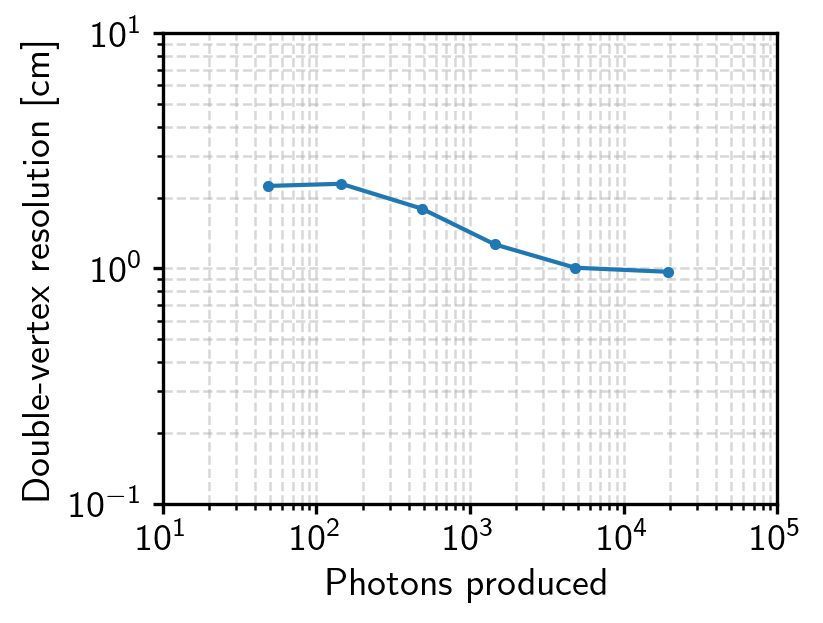

In [238]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.loglog(np.array(num_photons)*eff, resolutions/10., marker='.')
ax.set_xlabel('Photons produced')
ax.set_ylabel('Double-vertex resolution [cm]')
ax.set_xlim([1e1, 1e5])
ax.set_ylim([1e-1, 1e1])
ax.grid(which='both')

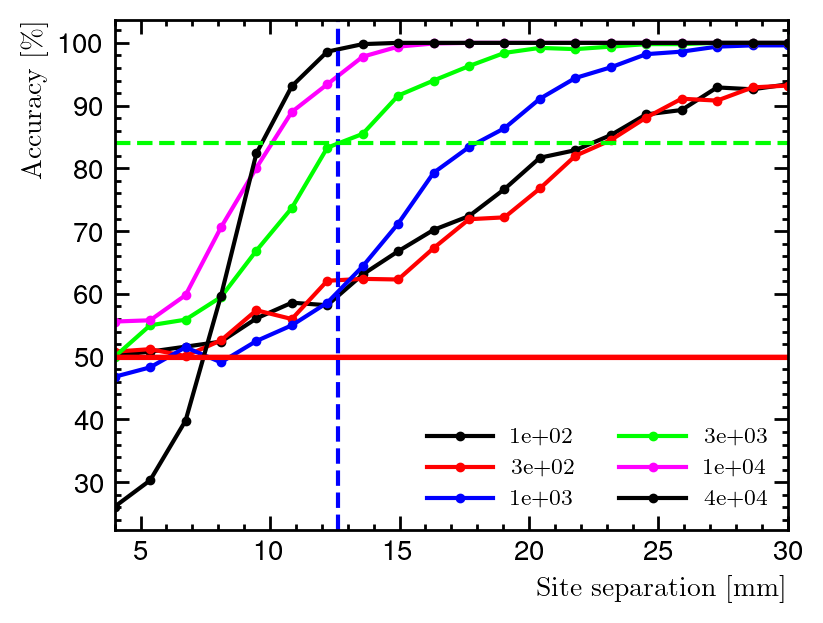

In [ ]:
plt.style.use('paper_style.mplstyle')
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(seps, acc_test/1000*1e2, marker='.', ms=5, label=['{:.0e}'.format(n) for n in num_photons])
[ax.axhline(k/1000*1e2, color='C1') for k in kept]#, label='Single-site accepted')
ind = np.argmin(np.abs(np.interp(np.linspace(0, np.amax(seps), 1000), seps, acc_test[:,-3]/1000*1e2) - 84.))
ax.axvline(np.linspace(0, np.amax(seps), 1000)[ind], ls='--', color='C2')
ax.axhline(np.interp(np.linspace(0, np.amax(seps), 1000)[ind], seps, acc_test[:,-3]/1000*1e2), ls='--', color='C3')
ax.set_xlabel('Site separation [mm]')
ax.set_ylabel(r'Accuracy [\%]')
ax.set_xlim([np.amin(seps), np.amax(seps)])
ax.legend(ncol=2, fontsize=8)
fig.savefig('cnn_acc_vs_sep.png')

/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_40660/3290497699.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(ncol=2, fontsize=8)


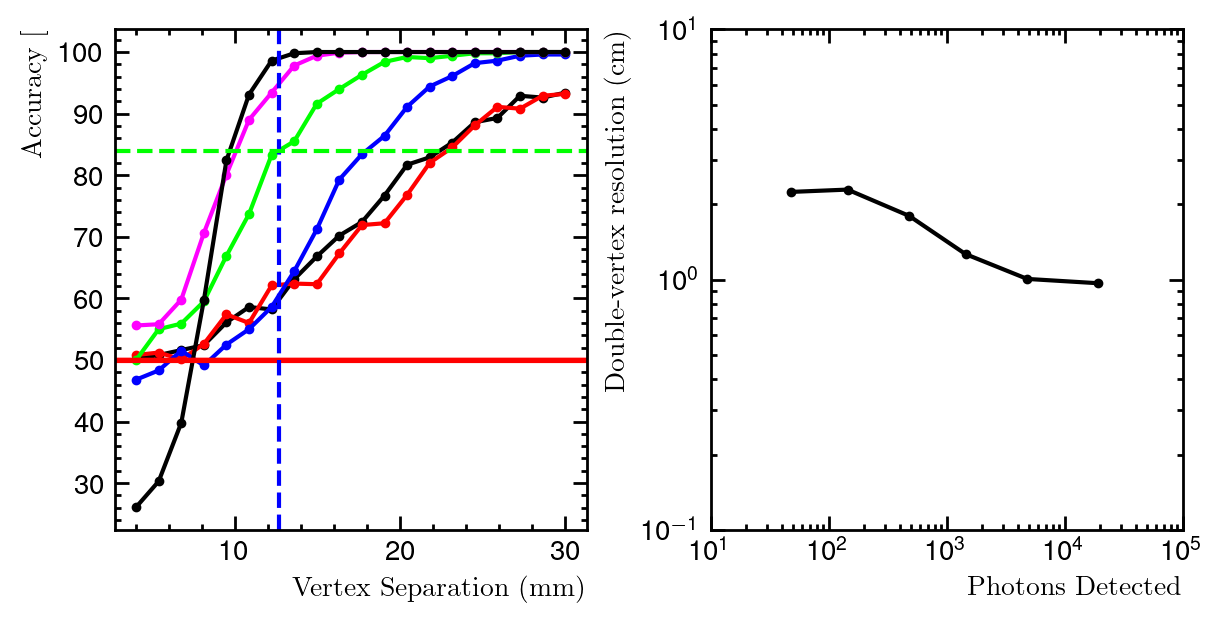

In [253]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')
ax[0].plot(seps, acc_test/1000*1e2, marker='.', ms=5, label=['{:.0e}'.format(n) for n in num_photons])
[ax[0].axhline(k/1000*1e2, color='C1') for k in kept]#, label='Single-site accepted')
ind = np.argmin(np.abs(np.interp(np.linspace(0, np.amax(seps), 1000), seps, acc_test[:,-3]/1000*1e2) - 84.))
ax[0].axvline(np.linspace(0, np.amax(seps), 1000)[ind], ls='--', color='C2')
ax[0].axhline(np.interp(np.linspace(0, np.amax(seps), 1000)[ind], seps, acc_test[:,-3]/1000*1e2), ls='--', color='C3')
ax[1].loglog(np.array(num_photons)*eff, resolutions/10., marker='.', ms=5)
ax[1].set_xlim([1e1, 1e5])
ax[1].set_ylim([1e-1, 1e1])
ax[0].set_xlabel('Vertex Separation (mm)')
ax[1].set_ylabel('Double-vertex resolution (cm)')
ax[1].set_xlabel('Photons Detected')
ax[0].set_ylabel('Accuracy [%]')
ax[1].legend(ncol=2, fontsize=8)

np.savez('data/plot_data.npz', seps=seps, acc_test=acc_test, num_photons=num_photons, kept=kept, eff=eff, resolutions=resolutions)

/Users/clarke/Documents/Research/Migdal/ss_ms_paper/ss_ms_utils.py:41: RuntimeWarning: divide by zero encountered in power
  return A*np.exp(-a*rho/(1 + rho**(1 - alpha)) - b/(1 + rho**(-alpha)))


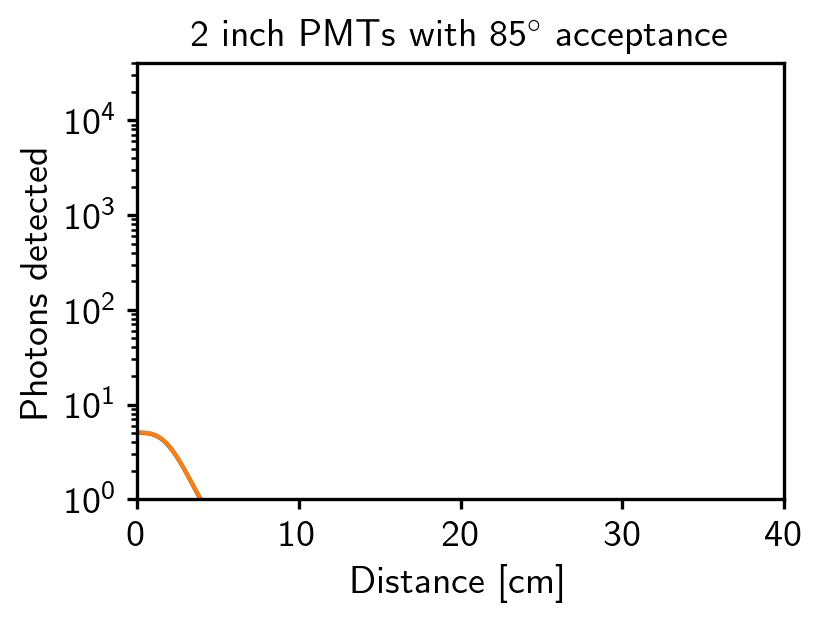

In [60]:
lrf_2inch_85deg_g4 = [2537.17/1e4*n_photons, 3.96, 0.88, 2.38, 3.16]
lrf_2inch_70deg_g4 = [2596.87/1e4*n_photons, 4.39, 4.62, -0.08, 2.86]

with open('data/LRF_51mm_85deg.yaml'.format(pmt_diam, acceptance), 'r') as f:
    lrf_dict = yaml.safe_load(f)
lrf_2inch_85deg_chroma = [n_photons*lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], \
                          lrf_dict['b_fit'], lrf_dict['alpha_fit']]

with open('data/chroma/LRF_51mm_70deg.yaml', 'r') as f:
    lrf_dict = yaml.safe_load(f)
lrf_2inch_70deg_chroma = [n_photons*lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], \
                          lrf_dict['b_fit'], lrf_dict['alpha_fit']]

rad_array = np.linspace(0, 40, 1000)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_85deg_chroma))
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_85deg_g4))
ax.set_ylim([1e0, 4e4])
ax.set_xlim([0, 40])
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Photons detected')
ax.set_title(r'2 inch PMTs with 85$^\circ$ acceptance', fontsize=14)
fig.savefig('g4_chroma_comparison_2inch_85deg.png')

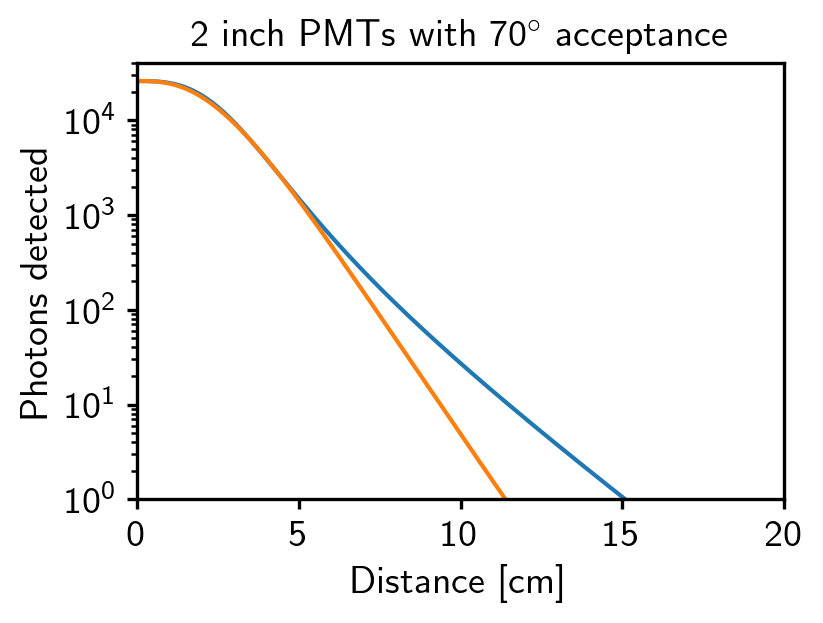

In [42]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_70deg_chroma), label='Chroma')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_70deg_g4), label='Geant4')
ax.set_ylim([1e0, 4e4])
ax.set_xlim([0, 20])
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Photons detected')
ax.set_title(r'2 inch PMTs with 70$^\circ$ acceptance', fontsize=14)
fig.savefig('g4_chroma_comparison_2inch_70deg.png')